# Configuring go environment
![](https://upload.wikimedia.org/wikipedia/commons/thumb/2/23/Go_Logo_Aqua.svg/1920px-Go_Logo_Aqua.svg.png)


In [1]:
!wget https://go.dev/dl/go1.21.1.linux-amd64.tar.gz
!sudo rm -rf /usr/local/go
!sudo tar -C /usr/local -xzf go1.21.1.linux-amd64.tar.gz
!export PATH=$PATH:/usr/local/go/bin
import os
os.environ["PATH"] += ":/usr/local/go/bin"

--2025-12-19 14:35:05--  https://go.dev/dl/go1.21.1.linux-amd64.tar.gz
Resolving go.dev (go.dev)... 216.239.34.21, 216.239.36.21, 216.239.38.21, ...
Connecting to go.dev (go.dev)|216.239.34.21|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.google.com/go/go1.21.1.linux-amd64.tar.gz [following]
--2025-12-19 14:35:05--  https://dl.google.com/go/go1.21.1.linux-amd64.tar.gz
Resolving dl.google.com (dl.google.com)... 74.125.204.136, 74.125.204.91, 74.125.204.190, ...
Connecting to dl.google.com (dl.google.com)|74.125.204.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66633012 (64M) [application/x-gzip]
Saving to: ‘go1.21.1.linux-amd64.tar.gz’

go1.21.1.linux-amd6 100%[===================>]  63.55M   270MB/s    in 0.2s    

2025-12-19 14:35:06 (270 MB/s) - ‘go1.21.1.linux-amd64.tar.gz’ saved [66633012/66633012]



# Go file to create and train a neuron

The goal is to create a single and simple neuron, which can find the good parameters to get a 5 as output for [1, 2] as input.

Reminder: a neuron will compute an output by applying params on input (one param per input : here W1 for x1, w2 for x2) and a bias.
The result should be used in an activation function to decide the value of the output. In order to make this exercice simple we disabled this function, so Y = w1x1 + w2x2 + b

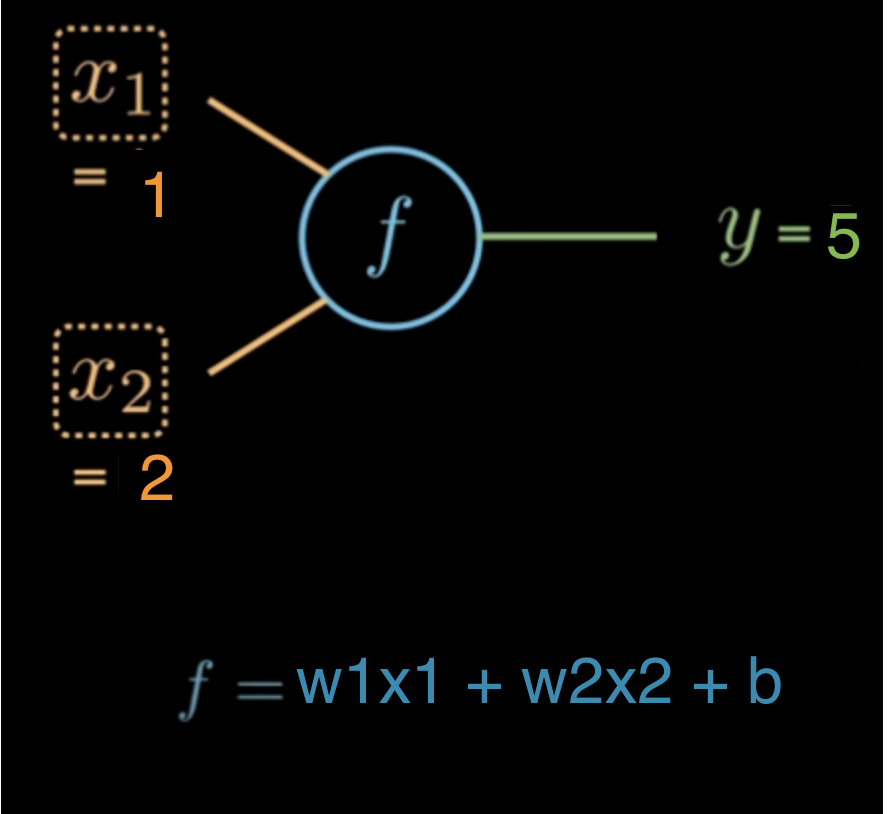

## index

**model** : the model of the neuron, it takes 2 inputs and return a value as output


**erreur (loss)** : We call "loss" the error between the desired value (5 here) and the current value the model obtained during training


In [38]:
%%writefile neurone.go
package main

import (
	"fmt"
	"math/rand"
  "math"
	"time"
  "os"
  "log"
)

// Initialize parameters and bias
func initialisation() ([2]float64, float64) {
	rand.New(rand.NewSource(time.Now().UnixNano()))

	// Box-Muller transform (normal law)
	normal := func() float64 {
		u1 := rand.Float64()
		u2 := rand.Float64()
		z := math.Sqrt(-2.0 * math.Log(u1)) * math.Cos(2.0 * math.Pi * u2)
		return z
	}

	W := [2]float64{normal(), normal()}
	b := normal()

	return W, b
}

// Linear model : z = w1*x1 + w2*x2 + b
func model(X [2]float64, W [2]float64, b float64) float64 {
	z := X[0]*W[0] + X[1]*W[1] + b
	return z
}

// Cost function
func loss(a, y float64) float64 {
	return (y - a)
}

// Compute gradient
func gap(a float64, X [2]float64, y float64) ([2]float64, float64) {
	dW := [2]float64{
		(y - a) * X[0],
		(y - a) * X[1],
	}
	db := y - a
	return dW, db
}

// Update weights (params)
func update(dW [2]float64, db float64, W [2]float64, b float64, learningRate float64) ([2]float64, float64) {
	W[0] += learningRate * dW[0]
	W[1] += learningRate * dW[1]
	b += learningRate * db

	return W, b
}

// Simple neuron
func artificialNeuron(X [2]float64, y float64, learningRate float64, nIter int) ([2]float64, float64) {

	 if X[0] <= 0 || X[1] <= 0 {
        log.Fatalf("Error: input values (X) should be greater than 0 , received: %v", X)
    }
    if y <= 0 {
        log.Fatalf("Error: ouput desired value (y) should be greater than 0, received: %v", y)
    }
    if learningRate <= 0 {
        log.Fatalf("Error: learningRate should be greater than 0, received: %v", learningRate)
    }
    if nIter <= 0 {
        log.Fatalf("Error: nIter should be greater than 0, received: %v", nIter)
    }

	W, b := initialisation()
	fmt.Println("Initial W:", W, "b:", b)

	losses := make([]float64, 0, nIter)
  accuracies := make([]float64, 0, nIter)

	for i := 0; i < nIter; i++ {
		fmt.Printf("\niteration %d-------------------------\n", i+1)
		fmt.Println("Current X:", X)
		fmt.Println("Current W:", W, "b:", b)
		yPred := model(X, W, b)
		lossVal := loss(yPred, y)
		losses = append(losses, lossVal)
    accuracyVal := yPred  * 100/y
    fmt.Println("accuracy", accuracyVal)
    accuracies = append(accuracies, accuracyVal)

		dW, db := gap(yPred, X, y)
		W, b = update(dW, db, W, b, learningRate)
		fmt.Println("Updated W:", W, "b:", b)
	}

  exportData(losses, accuracies)

	return W, b
}

func exportData(losses []float64, accuracies []float64) {
  file, err := os.Create("metrics.csv")
  if err != nil {
      panic(err)
  }
  defer file.Close()

  // header
  fmt.Fprintf(file, "epoch,loss,accuracy\n")

  // data written
  for i := 0; i < len(losses); i++ {
      fmt.Fprintf(file, "%d,%.4f,%.4f\n", i+1, losses[i], accuracies[i])
  }
}

func main() {
	X := [2]float64{1.0, 2.0}
	y := 5.0
	learningRate := 0.1
	nIter := 10

	W, b := artificialNeuron(X, y, learningRate, nIter)
	fmt.Println("\n\nEnd-------------------")
	fmt.Println("Final weights (params) :", W, "Final bias :", b)
  y_pred := model(X, W, b)
  fmt.Println("Prediction :",y_pred)
}

Overwriting neurone.go


# Running the neuron file to create and train our neuron

In [44]:
!go run neurone.go

Initial W: [-0.7639828855477203 -0.23618327598412134] b: 1.242355565991255

iteration 1-------------------------
Current X: [1 2]
Current W: [-0.7639828855477203 -0.23618327598412134] b: 1.242355565991255
accuracy 0.12012256950584277
Updated W: [-0.2645834983952495 0.7626154983208203] b: 1.741754953143726

iteration 2-------------------------
Current X: [1 2]
Current W: [-0.2645834983952495 0.7626154983208203] b: 1.741754953143726
accuracy 60.04804902780235
Updated W: [-0.06482374353426118 1.1621350080427968] b: 1.9415147080047142

iteration 3-------------------------
Current X: [1 2]
Current W: [-0.06482374353426118 1.1621350080427968] b: 1.9415147080047142
accuracy 84.01921961112092
Updated W: [0.015080158410134187 1.3219428119315875] b: 2.0214186099491096

iteration 4-------------------------
Current X: [1 2]
Current W: [0.015080158410134187 1.3219428119315875] b: 2.0214186099491096
accuracy 93.60768784444836
Updated W: [0.04704171918789237 1.3858659334871037] b: 2.053380170726868



# Use python to retrieve learning data and trace training metrics (loss and accuracy)

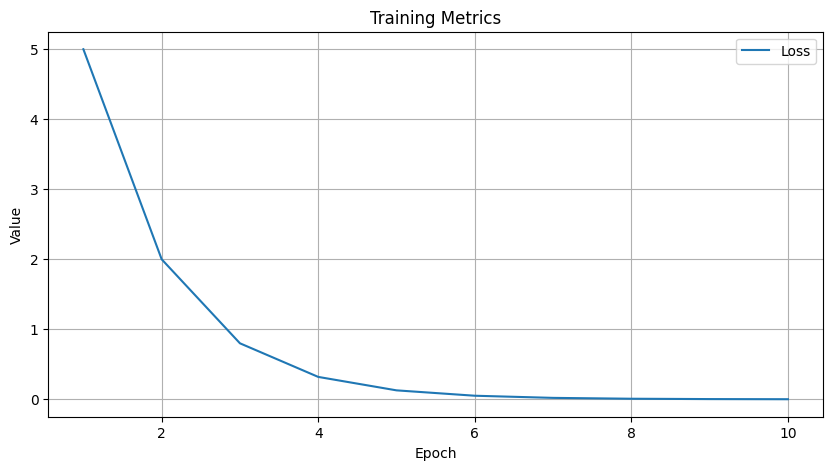

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Lire le fichier CSV créé par Go
df = pd.read_csv("metrics.csv")

# Tracer loss et accuracy
plt.figure(figsize=(10,5))
plt.plot(df['epoch'], df['loss'], label='Loss')
#plt.plot(df['epoch'], df['accuracy'], label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Metrics')
plt.legend()
plt.grid(True)
plt.show()